In [106]:
# imports
from astropy.io import fits
import numpy as np
import glob, os, sys, time
import matplotlib.pyplot as plt
import matplotlib
from scipy import stats
from scipy.ndimage.measurements import center_of_mass
from scipy.optimize import minimize_scalar
from scipy.optimize import leastsq
from scipy.optimize import least_squares
from scipy.interpolate import UnivariateSpline
from photutils import CircularAperture
from photutils import aperture_photometry
from photutils import CircularAnnulus
import batman
from tabulate import tabulate
from IPython.display import HTML
import emcee
import corner

# Custom imports
sys.path.insert(0, '{}/PhD/code/mySpitzerTransit/'.format(os.getenv('HOME')))
from timeseries_routines import *
from transitFitting_routines import *
sys.path.insert(1, '{}/PhD/code/'.format(os.getenv('HOME')))
from ProgressBar import *

In [50]:
planet='Kepler45b'
AOR = 'r47041792'
channel = 'ch1'

path = "{3}/PhD/SpitzerData/{0}/{1}/{2}/bcd/".format(planet,AOR,channel, os.getenv('HOME'))

# Read in the data
data_info = read_files(path)
exptime = data_info.exptime()
readnoise = data_info.readnoise()
gain = data_info.gain()
fluxconv = data_info.fluxconv()
framtime = data_info.framtime()
MJysr2lelectrons = exptime*gain/fluxconv
print MJysr2lelectrons
#Create timeseries, midtimes and maskseries
timeseries = data_info.create_timeseries()
midtimes = data_info.midtimes()

# Change from image units to electrons
timeseries = timeseries*MJysr2lelectrons

56.51551312649165

Reading data from '/Users/cbaxter/PhD/SpitzerData/Kepler45b/r47041792/ch1/bcd/' ... 
	 Timeseries created with shape (8064, 32, 32)
	 Midtimes created with shape (8064,)


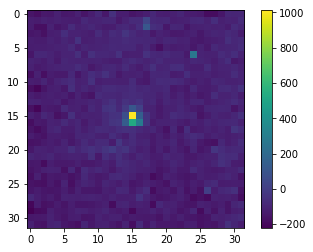

In [30]:
plt.imshow(timeseries[0]) # plot the first frame
plt.colorbar()

    for i in range(len(timeseries)):
        frame = timeseries[i]
        array = frame.flatten()
        iters = 5

        for j in range(iters):
            std_dev = np.std(array)
            median = np.median(array)

            array = array[array<median+std_dev] # This is a bit arbitrary...
            array = array[array>median-std_dev]

            median = np.median(array)

        newtimeseries[i] = timeseries[i] - median
        bkg.append(median)}

-108.75160690708206
29.68996525948827
28.055424064326687
35.652537880763234
45.17275279916841
30.95250496147356
27.638243081177052
57.47771634122353
36.554968886273
29.45161751175837
147.34471414424922
43.88733028512012
30.574701077044722
42.29436250745823
48.805745336491626
36.54539367748615
29.877167749518712
58.08400138181263
40.81046621099577
33.8515244804874


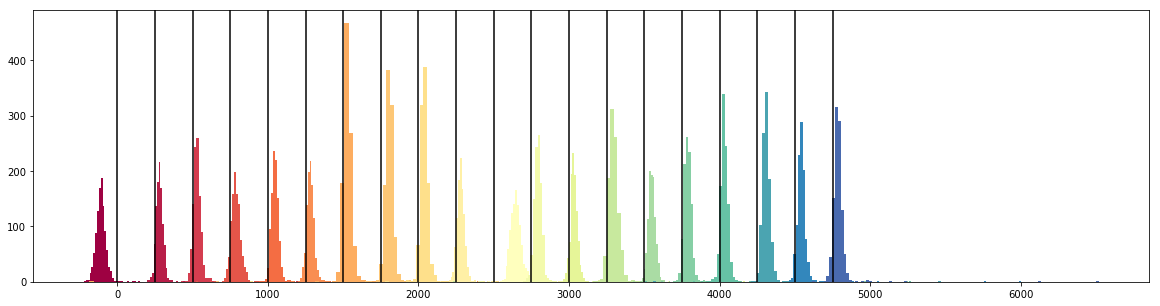

In [51]:
newtimeseries = np.ndarray(timeseries.shape)
bkg = []

# Don't do all the frames, but maybe 20 frames throughout the whole timeseries 
Nframes = 20 

cmap = matplotlib.cm.get_cmap('Spectral')

colours = [cmap(float(i)/float(Nframes)) for i in range(Nframes)]

fig, ax = plt.subplots(1,1,figsize=(20,5))

for i in range(Nframes): # len(timeseries)
    # frame
    iframe =  i*len(timeseries)/Nframes
    
    frame = timeseries[iframe]
    array = frame.flatten()
    bins = 100
    
    ax.hist(array + 250*i, bins = bins, color = colours[i])
    ax.axvline(250*i, c = 'k')
    iters = 1

    for j in range(iters):
        std_dev = np.std(array)
        median = np.median(array)

        array = array[array<median+std_dev] # This is a bit arbitrary...
        array = array[array>median-std_dev]

        median = np.median(array)
    print median
#     newtimeseries[iframe] = timeseries[iframe] - median
    bkg.append(median)

In [92]:
Flux = np.linspace(1000,120000,1000)
Error = np.sqrt(Flux)
Background = 0.62065*56 * np.pi*2.5**2 # multiply by the number of pixels in the aperture
BackgroundError = np.sqrt(Background)
print Background
print BackgroundError
#bkgK45 = np.mean(bkg)
#print bkgK45 # Just checking that the Kepler45 background and the average backgrounds are similar order of magnitude 

combinedError = [np.sqrt(f + Background) for f in Flux]

682.440318158
26.123558680962223


5407.407407407408


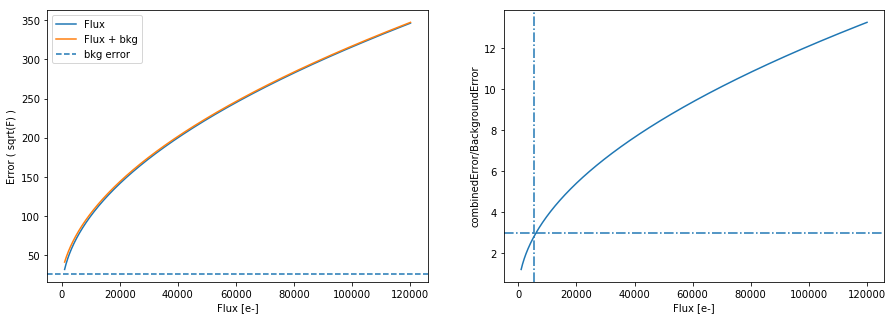

In [119]:
fig, ax = plt.subplots(1,2,figsize=(15,5))

ax[0].plot(Flux, Error, label='Flux')
ax[0].plot(Flux, combinedError, label = 'Flux + bkg')
ax[0].axhline(BackgroundError, linestyle = '--', label = 'bkg error')

#print (combinedError-Error)
ax[0].set_xlabel('Flux [e-]')
ax[0].set_ylabel('Error ( sqrt(F) )')
ax[0].legend()

ax[1].plot(Flux,Error/BackgroundError)
ind = np.where(combinedError/BackgroundError < 3)
criticalFlux = Flux[ind[0][-1]]
ax[1].axhline(3, linestyle='-.')
ax[1].axvline(criticalFlux, linestyle='-.')
print criticalFlux
ax[1].set_xlabel('Flux [e-]')
ax[1].set_ylabel('combinedError/BackgroundError')


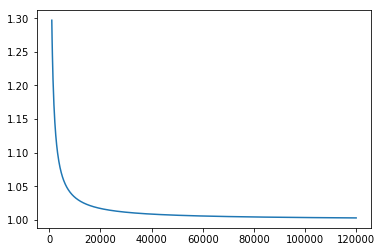

In [128]:
plt.plot(Flux, np.array(combinedError)/Error)

In [159]:
# Ingalls et al background calculation 
#sigma_int = 
sigma_rn = 9.4
FN = 8.
WT = 184.
nmax = 2.*FN + WT
deltat = 0.01
texp = (FN + WT)*deltat
tint = 2

sigma_int = 1
A =  2.*sigma_rn**2/(sigma_int**2*FN)
B = (1. - 
    (2.*FN/(3.*nmax)) + 
    (1/(6.*FN*nmax))  )

print (A/B)*(texp/tint)
print B
# The limit for where readout noise becomes important (electron counts)
print "Readout noise limit: {} e-".format((A/B)*(texp/tint)/B)
# Readout noise is insignificant for nearly all reasonable planets 

21.7850658106
0.9734375
Readout noise limit: 22.37952186 e-


In [163]:
Fap_bg = 3336 
Fap = 3436 #  estimated (not actually measured)
Fbg = 680 
sigma_ap = np.sqrt(Fap)
sigma_bg = np.sqrt(Fbg)
sigma_int = np.sqrt(sigma_ap**2 + sigma_bg**2)
var_e = sigma_int**2 * ( (2.*sigma_rn**2/(sigma_int**2*FN) + 
                          1. - 
                         (2.*FN/(3.*nmax)) + 
                         (1/(6*FN*nmax))  ))
print np.sqrt(var_e) # This is a useful number for my paper although i didn't measure the 

63.47250388947958


In [ ]:
# Calculate the rms of the centroids and compare is to the flux... 